# 1.0 importing libs

In [1]:
import pandas as pd
import numpy as np
from colour import Color
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines

# 2.0 importing and cleanning dataset

In [13]:
#Choose if you want to download from link or user a .csv file
data = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
#data = pd.read_csv("gmr.csv")

display(data.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529056 entries, 0 to 2529055
Data columns (total 14 columns):
 #   Column                                              Non-Null Count    Dtype  
---  ------                                              --------------    -----  
 0   country_region_code                                 2527360 non-null  object 
 1   country_region                                      2529056 non-null  object 
 2   sub_region_1                                        2485736 non-null  object 
 3   sub_region_2                                        2098066 non-null  object 
 4   metro_area                                          14035 non-null    object 
 5   iso_3166_2_code                                     444505 non-null   object 
 6   census_fips_code                                    564825 non-null   float64
 7   date                                                2529056 non-null  object 
 8   retail_and_recreation_percent_change_from_baseline  

None

In [10]:
#Get oly lines with Brazil information
data_br = data.loc[data.country_region=='Brazil'].iloc[:,[1,2,3,7,8,9,10,11,12,13]].copy()
#Rename columns
data_br.columns=["country","state","city","date","retail","grocery","parks","transit","workplaces","residential"]
#Rename Brazil states names
data_br.state = data_br.state.str.replace("State of ","")
#Convert date column to a pandas.datetime value
data_br.date = pd.to_datetime(data_br.date)
#Turn the date column the index of the dataframe
data_br.index = data_br.date
#Drop the old "date" column
data_br.drop(labels='date',axis=1,inplace=True)
#Create a dataframe only with the states information (when city value is null and state value is not null)
data_br_state = data_br.loc[~data_br.state.isnull() & data_br.city.isnull()].copy()

display(data_br_state.head())

,country,state,city,retail,grocery,parks,transit,workplaces,residential
date,,,,,,,,,
2020-02-15,Brazil,Federal District,NaN,10.0,7.0,-8.0,8.0,8.0,0.0
2020-02-16,Brazil,Federal District,NaN,11.0,6.0,-10.0,4.0,0.0,2.0
2020-02-17,Brazil,Federal District,NaN,2.0,4.0,-1.0,11.0,22.0,-2.0
2020-02-18,Brazil,Federal District,NaN,1.0,4.0,2.0,14.0,22.0,-2.0
2020-02-19,Brazil,Federal District,NaN,-2.0,0.0,-3.0,9.0,20.0,-2.0


# 3.0 functions

In [4]:
#Get the minimum and the last value from a pandas series
def getMinAndActual(serie):
    minimum = serie.loc[serie==serie.min()].tail(1)
    actual = serie.tail(1)
    return minimum.append(actual)

#Get the percentage recover value based on minimum and maximum
def recover(minimum,actual):
    value=0
    if(actual>=0):
        value = 100+abs((100/minimum)*actual)
    else:
        value = 100-abs((100/minimum)*abs(actual))
    return round(value,0)

#Group and unstack a dataframe 
def groupAndUnstack(dataframe,firstBy,secondBy):
    return dataframe.groupby(by=[firstBy,secondBy]).mean().unstack()

#Make a fancy plot of a highlighted panda series on a matplotlib axes
def plotHighlight(ax,highlight):
    ax.plot(highlight,color='white',linewidth=7,zorder=1)
    highlight_min_actual = getMinAndActual(highlight)
    minimum = (highlight_min_actual.index[0],highlight_min_actual[0])
    actual = (highlight_min_actual.index[1],highlight_min_actual[1])
    colors = list(Color("blue").range_to(Color("cyan"),100))+list(Color("cyan").range_to(Color("yellow"),100))
    colorMap = []
    #generate color range for the entrys
    for entry in highlight:
        colorMap.append(colors[100+int(entry)].hex)
    #plot the gradient line
    for i in range(highlight.count()-1):
        x = (highlight.index[i],highlight.index[i+1])
        y = (highlight[i],highlight[i+1])
        ax.plot(x,y,colorMap[i],linewidth=4,zorder=2)
        if (x[0],y[0]) == minimum:
            ax.scatter(x[0],y[0],marker='o',alpha=1,color=colorMap[i],linewidth=8,zorder=3)
        if (x[1],y[1]) == actual:
            ax.scatter(x[1],y[1],marker='o',alpha=1,color=colorMap[i],linewidth=8,zorder=3)
    ax.set_xlim(right=pd.Timestamp(actual[0]+pd.DateOffset(5)))
    #annotate on the plot the minumum and actual values
    ax.annotate(str(round(minimum[1],0))+"%",xy=(minimum[0],minimum[1]),color='black',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)
    ax.annotate(str(round(actual[1],0))+"%",xy=(actual[0],actual[1]),color='black',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)
    #show difference between minimum and actual
    ax.plot([minimum[0],actual[0]],[minimum[1],minimum[1]],color="black",linestyle="--",linewidth=2)
    ax.plot([actual[0],actual[0]],[minimum[1],actual[1]],color="black",linestyle="--",linewidth=2)
    ax.annotate(str(recover(minimum[1],actual[1]))+"%",xy=(actual[0],(minimum[1]+actual[1])/2),color='red',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)

#Simple plot gray lines on a matplotlib axes
def simplePlot(ax,lines):
    lines.plot(ax=ax,color='grey',linewidth=2,alpha=0.4,legend=False,zorder=1)

# 4.0 Plotting data

In [5]:
#Run and choose a matplotlib style for the image
print(plt.style.available)
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<ipython-input-6-2ebf793257f1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["","Março","Abril","Maio","Junho","Julho","Agosto","Setembro"],fontsize=12)


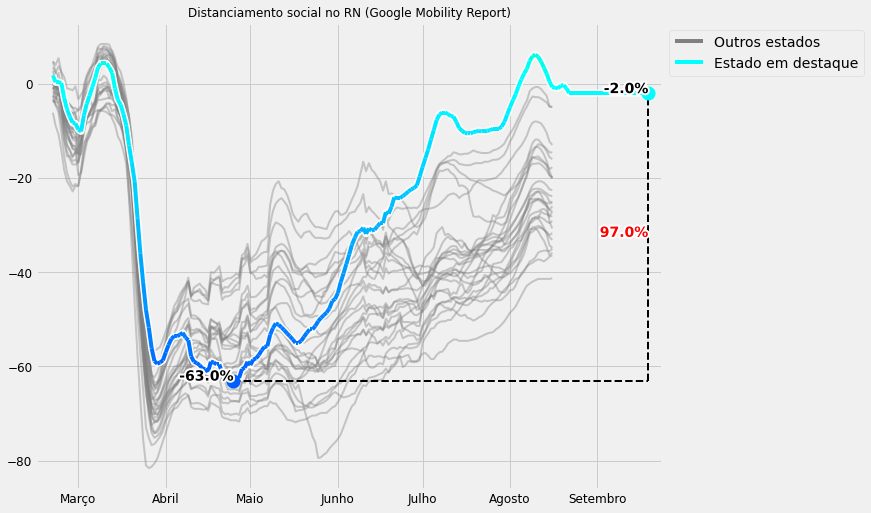

In [6]:
#First lets test the function with only one state to get a bigger image

#Create the subplot axes and figure
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,8))

#Change the figure target item and state (google mobility report variables)
item='retail'
highlight_state = 'Amazonas'

#Get the data separated Highlited state and the others (lines)
lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][highlight_state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

#Plot the data
simplePlot(ax,lines)
plotHighlight(ax,highlight)

#Create the legend lines
others_state = mlines.Line2D([], [],color='gray', label='Outros estados')
highlight_state =  mlines.Line2D([], [],color='cyan', label='Estado em destaque')

#Change the plot legend, tick labels and title
ax.legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
ax.set_xticklabels(["","Março","Abril","Maio","Junho","Julho","Agosto","Setembro"],fontsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Distanciamento social no RN (Google Mobility Report)",fontsize=12)
ax.set_xlabel("")

#plt.savefig("MovingAverageFigure.png",dpi=300)
plt.show()

<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-7-a35a49787e1a>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xtick

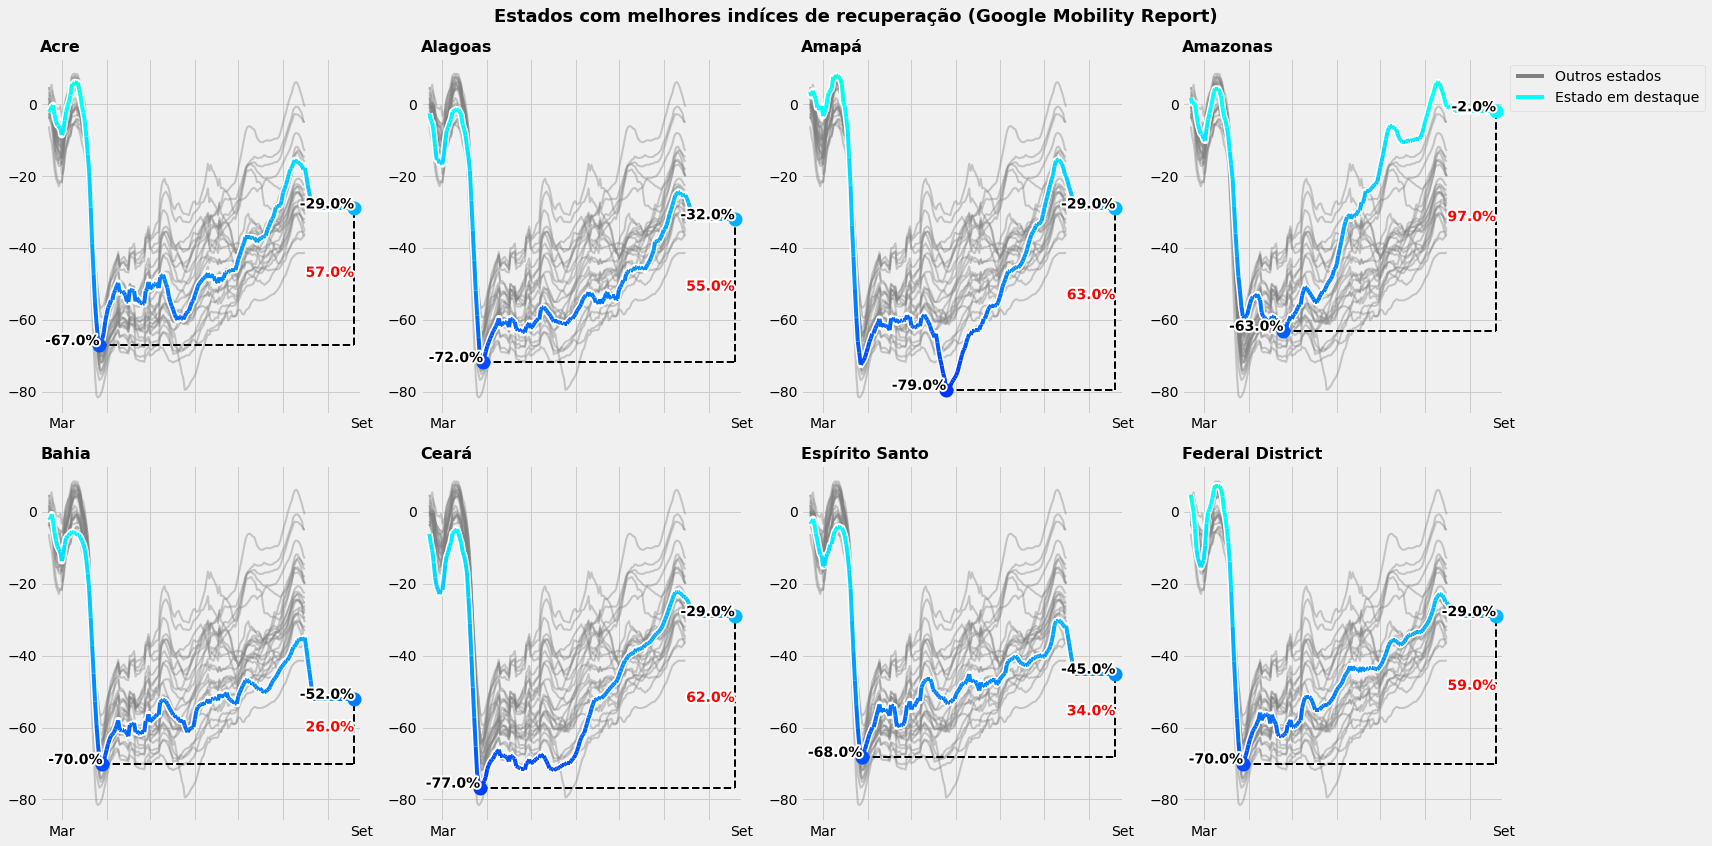

In [7]:
#Now let's use a for loop to plot multiple graphs with organized information

#Define the figure number of graphs
lines=2
cols=4
size=lines*cols

#Create the matplotlib subplots
fig,ax = plt.subplots(nrows=lines,ncols=cols,figsize=(cols*6,lines*6))

#Change figure title and target item
fig.suptitle('Estados com melhores indíces de recuperação (Google Mobility Report)', fontsize=18,fontweight='bold')
item='retail'

#Get the top states with better recover values sorted
stacked = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
top_states = stacked.apply(lambda x:recover(x.min(),x.iloc[-1])).sort_values(ascending=False).head(size)

#Create the legend lines
others_state = mlines.Line2D([], [],color='gray', label='Outros estados')
highlight_state =  mlines.Line2D([], [],color='cyan', label='Estado em destaque')

#With the type (line x cols) type of figure, plot the data
if(size==1):
    state = top_states.index[0]

    lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
    highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

    simplePlot(ax,lines)
    plotHighlight(ax,highlight)

    ax.set_title(state,fontsize=16,loc='left',fontweight='bold')
    ax.set_xlabel("")
    labels = ["" for item in ax.get_xticklabels()]
    labels[1]="Mar"
    labels[len(labels)-1]="Set"
    ax.set_xticklabels(labels)
    ax.legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
elif(lines==1 or cols==1):
    for i in range(size):
        state = top_states.index[i]

        lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
        highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

        simplePlot(ax[i],lines)
        plotHighlight(ax[i],highlight)

        ax[i].set_title(state,fontsize=16,loc='left',fontweight='bold')
        ax[i].set_xlabel("")
        labels = ["" for item in ax[i].get_xticklabels()]
        labels[1]="Mar"
        labels[len(labels)-1]="Set"
        ax[i].set_xticklabels(labels)
        ax[size-1].legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
else:
    for i in range(lines):
        for j in range(cols):
            state = top_states.index[i*cols+j]

            lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
            highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

            simplePlot(ax[i][j],lines)
            plotHighlight(ax[i][j],highlight)

            ax[i][j].set_title(state,fontsize=16,loc='left',fontweight='bold')
            ax[i][j].set_xlabel("")
            labels = ["" for item in ax[i][j].get_xticklabels()]
            labels[1]="Mar"
            labels[len(labels)-1]="Set"
            ax[i][j].set_xticklabels(labels)
            ax[0][cols-1].legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)

plt.tight_layout()
plt.savefig("1FP.png",dpi=200)
plt.show()